## Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier

# Import our bias evaluation function
# TODO: figure it out how to set project root in the path
import sys
sys.path.append('./../../src')
from model_bias_analysis import compute_bias_metrics_for_model

## Dataset

Read the train data

In [2]:
data_path = '../../data'
train = pd.read_csv(os.path.join(data_path, 'train.csv'))
train['comment_text'] = train['comment_text'].fillna('')

## Identities and Toxicity Targets

Here we defined the targets that we want our model to predict and the main identities of focus for calculating the unintended bias.

In [3]:
targets = [
    "target", 
    "severe_toxicity", 
    "obscene", 
    "identity_attack", 
    "insult", 
    "threat"
]

main_identities = [
    'male', 
    'female', 
    'homosexual_gay_or_lesbian',
    'christian', 'jewish', 
    'muslim', 
    'white', 
    'black',
    'psychiatric_or_mental_illness'
]

# Binarize the main identities and targets from the train set
for col in main_identities + targets:
    train[col] = np.where(train[col] >= 0.5, True, False)

## Train & Validation Split

And important step here is to pay atention to how the data is set. The functions for evaluating the bias expect to receive as parameters, a dataframe with text comments, toxicity true labels, predicted score and subgroups.

We build the validation set with that in mind, separating the original train DataFrame into two separate DataFrames: train and validation

In [4]:
# I let copilot generate the stratify split code, I don't know how stratify behaves with multilabel data
train_df, val_df = train_test_split(
    train, test_size=0.1, random_state=42, stratify=train[targets].any(axis=1))

y_train = train_df[targets]
y_val = val_df[targets]

## Text Vectorizing

In [5]:
%%time
# Vectorize text
tokenizer = TweetTokenizer()
vectorizer = TfidfVectorizer(ngram_range=(1, 2), tokenizer=tokenizer.tokenize, max_features=30000)

# Transforms the train and validation sets into TF-IDF vectors
# This will take a while, so be patient
train_vectorized = vectorizer.fit_transform(train_df["comment_text"].values)
val_vectorized = vectorizer.transform(val_df["comment_text"].values)

/Users/eduardoduarte/Projects/toxic-comments/venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 4min 2s, sys: 2.94 s, total: 4min 5s
Wall time: 4min 5s


## Training the Logistic Regressor

In [6]:
%%time
# Build and fit MultiOutputClassifier
base_clf = LogisticRegression(solver='liblinear')
multi_clf = MultiOutputClassifier(base_clf)
multi_clf.fit(train_vectorized, y_train)

CPU times: user 1min 14s, sys: 1.37 s, total: 1min 15s
Wall time: 1min 15s


MultiOutputClassifier(estimator=LogisticRegression(solver='liblinear'))

## Prediction

The model predicts the toxicity of the comment and 5 other types of toxicity, defined in the targets list.

We are only insterested in the main toxicity target to calculate the bias. Below is what the model predicts for a given comment

In [7]:
multi_clf.predict_proba(vectorizer.transform(["Hello World!"]))

[array([[0.98180347, 0.01819653]]),
 array([[9.99981251e-01, 1.87490138e-05]]),
 array([[0.99730219, 0.00269781]]),
 array([[0.99443491, 0.00556509]]),
 array([[0.9903677, 0.0096323]]),
 array([[0.99825782, 0.00174218]])]

In [8]:
pred_col = "predicted_toxicity"
# Pick only the toxicity prediction score
val_df[pred_col] = multi_clf.predict_proba(val_vectorized)[0][:, 1]

# Calculates the bias metrics for the model
bias_metrics_results = compute_bias_metrics_for_model(
    val_df, main_identities, 'target', pred_col)

bias_metrics_results

,subgroup,subgroup_size,subgroup_auc,bpsn_auc,bnsp_auc,negative_aeg,positive_aeg
8,psychiatric_or_mental_illness,496,0.882593,0.827179,0.963519,0.250230,0.034620
4,jewish,749,0.856466,0.845948,0.941684,0.226041,-0.013047
2,homosexual_gay_or_lesbian,1156,0.800467,0.763201,0.956304,0.306818,0.000137
7,black,1463,0.792139,0.746463,0.959095,0.345056,0.012327
5,muslim,2089,0.787322,0.783853,0.949667,0.318707,-0.050407
6,white,2498,0.823361,0.755114,0.966137,0.345905,0.025543
3,christian,4055,0.890600,0.910552,0.919296,0.052082,-0.074260
0,male,4542,0.897923,0.860359,0.958139,0.191873,0.017517
1,female,5403,0.877450,0.867172,0.945257,0.182717,-0.031321


## Terrible Visualization, yet to complete

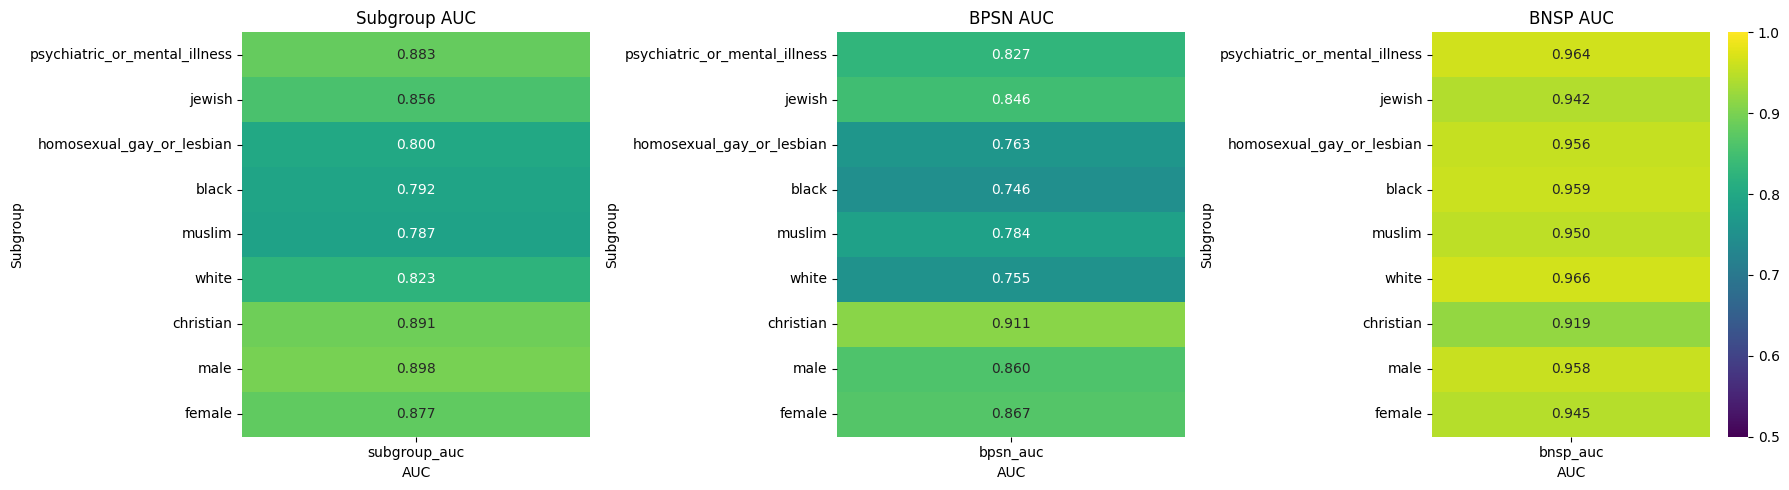

In [9]:
from model_bias_analysis import SUBGROUP_AUC, BPSN_AUC, BNSP_AUC, SUBGROUP

def plot_all_auc_heatmaps(bias_metrics_results, figsize=(18, 5), cmap='viridis'):
    """
    Plots heatmaps for all three AUC metrics (subgroup_auc, bpsn_auc, bnsp_auc) side by side.

    Parameters
    ----------
    bias_metrics_results : pd.DataFrame
        DataFrame returned by compute_bias_metrics_for_model.
    figsize : tuple
        Figure size for the plot.
    cmap : str
        Colormap for the heatmap.
    """
    auc_metrics = [SUBGROUP_AUC, BPSN_AUC, BNSP_AUC]
    titles = ["Subgroup AUC", "BPSN AUC", "BNSP AUC"]
    data = bias_metrics_results.set_index(SUBGROUP)
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    for i, (auc_col, title) in enumerate(zip(auc_metrics, titles)):
        sns.heatmap(
            data[[auc_col]],
            annot=True,
            fmt=".3f",
            cmap=cmap,
            vmin=0.5,
            vmax=1.0,
            cbar=(i == 2),
            ax=axes[i]
        )
        axes[i].set_title(title)
        axes[i].set_ylabel("Subgroup")
        axes[i].set_xlabel("AUC")
    plt.tight_layout()
    plt.show()

# Example usage:
plot_all_auc_heatmaps(bias_metrics_results)